# Plotting Sign distributions

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

from utils import *

## Saving all the Sign Distribution Plots

Get all the sign distributions, create their plots and store them as images:

In [2]:
# get sign distribution of each single WT and store plot

def store_sign_distr_plots(n, name):

    for i in range(n):
        # get sign distribution
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        # get two subsets, one for each layer
        sign_distr_layer1 = sign_distr[sign_distr["layer"]=="dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
        sign_distr_layer2 = sign_distr[sign_distr["layer"]=="dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
        # make and store the plots
        plot_1 = pretty_coll_sign_distr_plot(sign_distr_layer1, alpha=0.4)
        plot_2 = pretty_coll_sign_distr_plot(sign_distr_layer2, alpha=0.5)
        plot_1.savefig(f"3b Plots/{name}_dense1_{i}_sign_distr.png")
        plot_2.savefig(f"3b Plots/{name}_dense2_{i}_sign_distr.png")


def store_collective_sign_distr_plots(n, name):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n):
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])
    # seperate the dataframe by layer
    coll_sign_distr_layer1 = coll_sign_distr[coll_sign_distr["layer"]=="dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    coll_sign_distr_layer2 = coll_sign_distr[coll_sign_distr["layer"]=="dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    # make and store one plot for each layer
    plot_1 = pretty_coll_sign_distr_plot(coll_sign_distr_layer1)
    plot_2 = pretty_coll_sign_distr_plot(coll_sign_distr_layer2)
    plot_1.savefig(f"3b Plots/{name}_dense1_all_sign_distr.png")
    plot_2.savefig(f"3b Plots/{name}_dense2_all_sign_distr.png")

In [3]:
wts_per_dataset = 15

In [4]:
# save all the plots

#for dataset in tqdm(["SVHN_IMP","CINIC_IMP","CIFAR_IMP","RSN"], leave=False, desc="model type"):
    
    #store_sign_distr_plots(wts_per_dataset, dataset)
    #store_collective_sign_distr_plots(wts_per_dataset, dataset)


### Store 1 dimesnional sign distribution plots

In [5]:
def get_collective_sign_distr(name, n_wts):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n_wts):
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])
    return coll_sign_distr

In [6]:
def get_super_coll_sign_distr():
    super_coll_sign_distr = pd.DataFrame()
    for dataset in ["CIFAR_IMP","CINIC_IMP","SVHN_IMP","RSN"]:
        coll_sign_distr = get_collective_sign_distr(dataset, 15)
        coll_sign_distr["model"] = dataset
        super_coll_sign_distr = pd.concat([super_coll_sign_distr, coll_sign_distr])
    return super_coll_sign_distr

In [35]:
def get_and_store_1d_plots():

    fig, axes = plt.subplots(4, 2, figsize=(8,10), constrained_layout=True)

    # process dataframe
    super_coll_sign_distr = get_super_coll_sign_distr()
    for c, layer in enumerate(["dense1", "dense2"]):
        coll_sign_distr = super_coll_sign_distr[super_coll_sign_distr["layer"] == layer][["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out","model"]]
        coll_sign_distr = coll_sign_distr.replace(["CIFAR_IMP","CINIC_IMP","SVHN_IMP","RSN"], ["WT(CIFAR)","WT(CINIC)","WT(SVHN)","RSN"])
        coll_sign_distr = coll_sign_distr.melt("model", var_name='variable', value_name='value').sort_values(['model']).reset_index(drop=True)

        # build each subplot
        for r, variable in enumerate(["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out"]):
            distr = coll_sign_distr[coll_sign_distr["variable"] == variable][["value","model"]]
            
            # kernel density estimation
            if len(set(distr["value"])) >= 30:
                plot = sns.kdeplot(data=distr, hue='model',hue_order = ["WT(CIFAR)","WT(CINIC)","WT(SVHN)","RSN"],x='value',legend=False,fill=True, ax=axes[r,c], alpha=0.1)
                axes[r,c].set_ylabel("number of neurons\n(density estimation)")
            
            # pointplot (if few unique values)
            else:
                plot = sns.pointplot(data=distr.groupby(["value","model"]).size().reset_index(name='counts'), 
                                     hue='model',hue_order = ["WT(CIFAR)","WT(CINIC)","WT(SVHN)","RSN"],
                                     x='value', y="counts", ax=axes[r,c],markers=".")
                x_labels = list(set(distr["value"]))
                x_labels.sort()
                axes[r,c].set_xticklabels([str(np.round(x,2)) for x in x_labels])
                axes[r,c].set_ylabel("number of neurons\n(counts)")

    # naming rows and cols
    pad = 10
    for ax, col in zip(axes[0], ["dense1", "dense2"]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
    for ax, row in zip(axes[:,0], ["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out"]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
        
    # print and store plot
    plt.show()
    fig.savefig(f"3b Plots/1dimensional_plots_sign_distr_all.png")

/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future vers

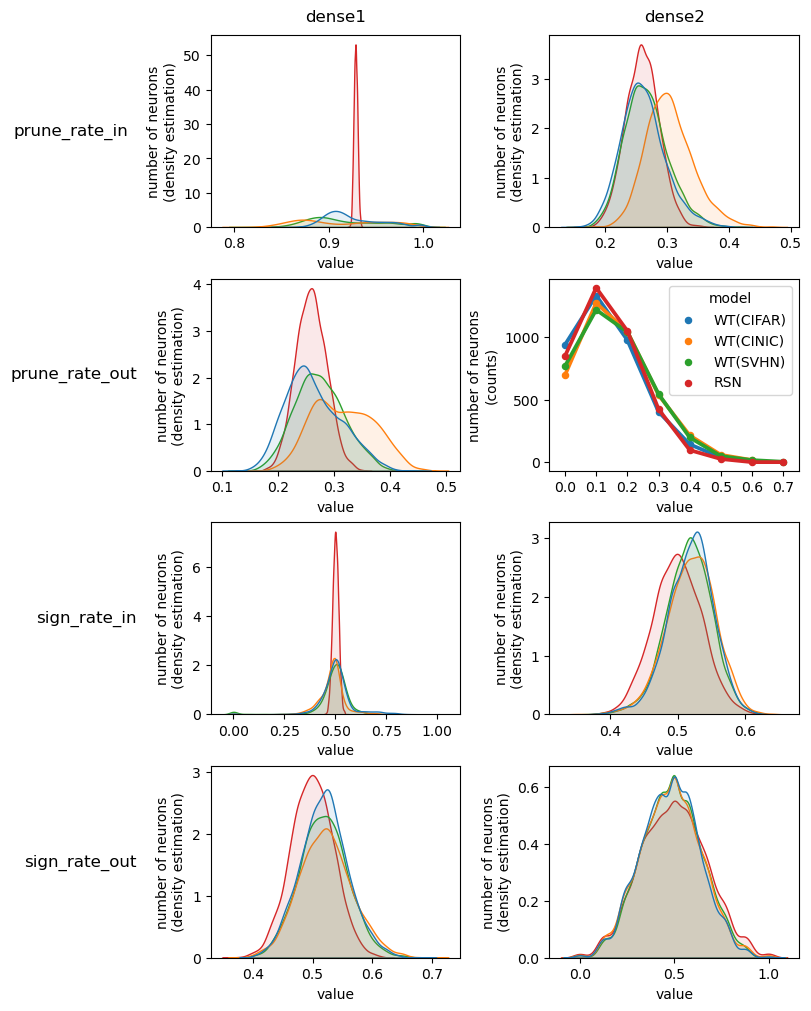

In [36]:
get_and_store_1d_plots()

## Unconnected Statistics

CIFAR: mean 10.6, std 5.499090833947008, 4.140625%
CINIC: mean 42.4, std 10.88607673437344, 16.5625%
SVHN: mean 31.4, std 7.863841300535, 12.265625%
RSN: mean 0.0, std 0.0, 0.0%


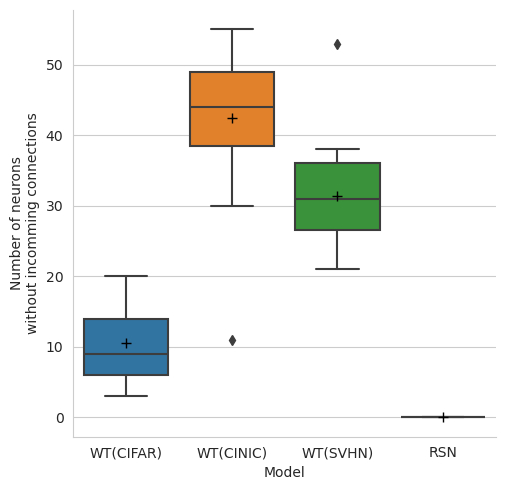

In [39]:

# collect unconnected statistics for each dataset
unconnected_statistics_all = pd.DataFrame()
datasets = ["CIFAR","CINIC","SVHN","RSN"]
for dataset in datasets:

    # load statistics
    if dataset == "RSN":
        unconnected_statistics = pd.read_csv(f'2b Sign distributions/{dataset}_unconnected_statistic.csv')
    else: 
        unconnected_statistics = pd.read_csv(f'2b Sign distributions/{dataset}_IMP_unconnected_statistic.csv')

    # filter statistics
    filtered_statistics = unconnected_statistics[unconnected_statistics["layer"] == "dense1"]
    filtered_statistics = filtered_statistics["no_incomming"]

    # combine statistics
    filtered_statistics.rename(dataset, inplace = True)
    unconnected_statistics_all = pd.concat([unconnected_statistics_all, filtered_statistics], axis=1)

    # print mean, std and ratio
    print(f"{dataset}: mean {np.mean(filtered_statistics)}, std {np.std(filtered_statistics)}, {np.mean(filtered_statistics)*100/256}%")

unconnected_statistics_all = unconnected_statistics_all.melt(var_name='model', value_name='n_unconnected').reset_index(drop=True)
unconnected_statistics_all = unconnected_statistics_all.replace(["CIFAR","CINIC","SVHN","RSN"], ["WT(CIFAR)","WT(CINIC)","WT(SVHN)","RSN"])

sns.set_style("whitegrid")
g = sns.catplot(data=unconnected_statistics_all, x="model", y="n_unconnected", kind="box", hue="model", dodge=False, 
                showmeans=True, meanprops={"marker": "+","markeredgecolor": "black","markersize": "7"})
#g.fig.suptitle("Disconnected neurons in dense1 layers")
g.set_axis_labels("Model","Number of neurons\nwithout incomming connections") 
g.savefig(f"3b Plots/unconnected_neurons_IMP_dense1.png")